# Plot precip to contextualize drought metrics
We have been studying SPEI in context with percent glaciation and with historical aridity index.  We know from Finn's work that glacier models modify the incoming precip over glaciers, sometimes by a lot.  Is this at play in the basins where we see differences among the models' drought indices?

18 Jun 2024 | EHU
- 19 Jun 24: Added full set of 11 GCMs that Sloan pulled.  Updating model names accordingly.

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
import gSPEI as gSPEI

In [107]:
default_colors = cm.get_cmap('plasma')

## Preliminary step: plot GCM precip directly
We have been showing a plot from Sloan that compares CMIP6 model dispersion in total basin precip over the Rhone.  What is the spread in our selected set of models?

In [53]:
## Define the filepath streamed from Google Drive
fpath = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/GCM-PET_Precip/'


## Settings in filenames -- slightly different model names and scenarios
# modelnames_provis = ['BCC.BCC-CSM2-MR',
#                     'MPI-M.MPI-ESM1-2-HR',
#                     'MRI.MRI-ESM2-0',
#                     'NCAR.CESM2-WACCM',
#                     'NCC.NorESM2-MM']
modelnames = ['BCC-CSM2-MR',
              'MPI-ESM1-2-HR',
              'MRI-ESM2-0',
              'CESM2-WACCM',
              'NorESM2-MM',
              'FGOALS-f3-L',
              'GFDL-ESM4',
              'INM-CM4-8',
              'INM-CM5-0',
              'EC-Earth3',
              'EC-Earth3-Veg']
# scenarios = ['Ssp2p6', 'Ssp4p5', 'Ssp7p0', 'Ssp8p5'] # climate scenarios
scenarios = ['Ssp4p5', 'Ssp8p5'] # climate scenarios included for 11 GCM set


yrs = np.linspace(1900, 2101, num=2412) # time interval over which we have data

In [54]:
## Basins in the order they are written
basins_all = {'RHINE':'6242', 'RHONE':'6243','PO':'6241', 'DANUBE':'6202', 'TITICACA':'3912', 'SANTA':'3425', 
            'OCONA':'3418', 'MAJES':'3416', 'MAGDALENA':'3227', 'AMAZON':'3203', 'YELCHO':'3429', 
            'VALDIVIA':'3428', 'SERRANO':'3426', 'RAPEL':'3423', 'PUELO':'3422', 'PASCUA':'3420', 
            'PALENA':'3419', 'HUASCO':'3412', 'COPIAPO':'3409', 'CISNES':'3408', 'BIOBIO':'3405', 'BAKER':'3404',
            'AZOPARDO':'3403', 'AISEN':'3401', 'SANTA CRUZ':'3244', 'NEGRO':'3232', 'COLORADO':'3212', 
            'CHICO':'3209', 'TORNEALVEN':'6255', 'THJORSA':'6254', 'OLFUSA':'6237', 'LULEALVEN':'6227', 
            'KUBAN':'6223', 'KALIXALVEN':'6219', 'GLOMAA':'6213', 'DRAMSELVA':'6209', 'SVARTA':'6110', 
            'LAGARFLJOT':'6104', 'JOKULSA A FJOLLUM':'6101', 'CLUTHA':'5406', 'YUKON':'4435', 'TAKU':'4431', 
             'SUSITNA':'4430','STIKINE':'4428', 'SKEENA':'4427','SKAGIT':'4426','NUSHAGAK':'4418','NASS':'4416',
            'KUSKOKWIM':'4414','FRASER':'4410', 'COPPER':'4408', 'COLUMBIA':'4406', 'ALSEK':'4401', 'NELSON':'4125', 
              'MACKENZIE':'4123','COLVILLE':'4110', 'YSYK-KOL':'2919', 'UVS NUUR':'2918', 'TARIM HE':'2914', 
              'TALAS':'2913', 'LAKE BALKHASH':'2910','HAR US NUUR':'2909', 'CHUY':'2905', 'ARAL SEA':'2902', 
              'YELLOW RIVER':'2434', 'MEKONG':'2421', 'KAMCHATKA':'2413', 'SALWEEN':'2319', 'IRRAWADDY':'2310', 
              'INDUS':'2309', 'GANGES':'2306','BRAHMAPUTRA':'2302', 'OB':'2108', 'INDIGIRKA':'2103','YANGTZE' : '2433'}

In [55]:
P_by_model = {m: {} for m in modelnames}
for m in modelnames:
    for s in scenarios:
        example_p = fpath+'{}_PREC_{}.txt'.format(m,s)
        P_by_model[m][s] = np.loadtxt(example_p)

In [56]:
import pandas as pd 

P_by_basin = {b: {} for b in basins_all} # precipitation by basin

for i, b in enumerate(basins_all):
    P_by_basin[b] = {s: {} for s in scenarios}
    for s in scenarios:
        tempdict_p = {}
        for m in modelnames:
            tempdict_p[m] = P_by_model[m][s][i]
        P_by_basin[b][s] = pd.DataFrame.from_dict(tempdict_p)

In [57]:
P_by_basin['RHONE']

{'Ssp4p5':        BCC-CSM2-MR  MPI-ESM1-2-HR    MRI-ESM2-0   CESM2-WACCM    NorESM2-MM  \
 0     1.145700e+11   7.663136e+10  1.082746e+11  6.571265e+10  5.210300e+10   
 1     8.417156e+10   1.190458e+11  5.254425e+10  1.128052e+11  1.062829e+10   
 2     1.329499e+11   1.115807e+11  1.184090e+11  1.035825e+11  7.154255e+10   
 3     7.984321e+10   1.437306e+11  9.575836e+10  6.462138e+10  6.051710e+10   
 4     1.416206e+11   2.018947e+11  1.847337e+11  1.045316e+11  1.099684e+11   
 ...            ...            ...           ...           ...           ...   
 2407  1.191856e+11   1.593891e+11  1.945419e+11  1.319846e+11  1.538626e+11   
 2408  9.364693e+10   1.930874e+11  2.271048e+11  1.722119e+11  9.237302e+10   
 2409  1.933386e+11   2.143740e+11  1.651728e+11  1.405817e+11  1.065421e+11   
 2410  1.772082e+11   2.240449e+11  1.498222e+11  1.474028e+11  1.194428e+11   
 2411  1.271783e+11   1.793442e+11  1.566865e+11  1.526557e+11  1.336301e+11   
 
        FGOALS-f3-L     GFDL

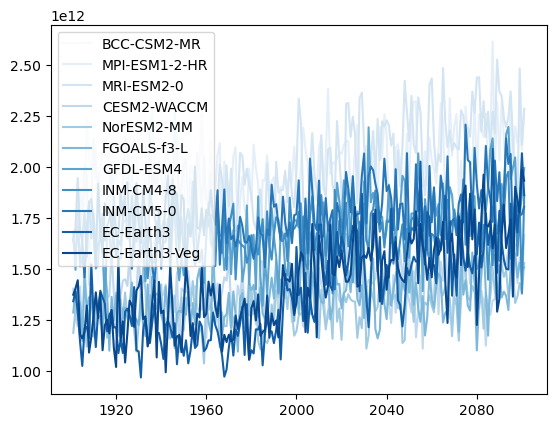

In [82]:
this_basin = 'RHONE'
rng = pd.date_range('1900-01-01', periods=2412, freq='M')

fig, ax = plt.subplots()
for i,this_GCM in enumerate(modelnames):
    this_precip = pd.Series(P_by_basin[this_basin]['Ssp4p5'][this_GCM])
    this_precip.index=rng
    ax.plot(this_precip.resample('A').sum(), label=this_GCM, color=default_colors(i/len(modelnames)))
ax.legend(loc='best')

There are some pronounced offsets here.  Sloan previously plotted mm/day relative to 2000-2020...try that.  Will have to re-do units and remove 2000-2020 mean.

/var/folders/1w/5s0157gx20d0jd0hrtvmpmh40000gp/T/ipykernel_1531/2206593472.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.set(xlim=(pd.datetime(1999,12,31),pd.datetime(2100,12,31)),


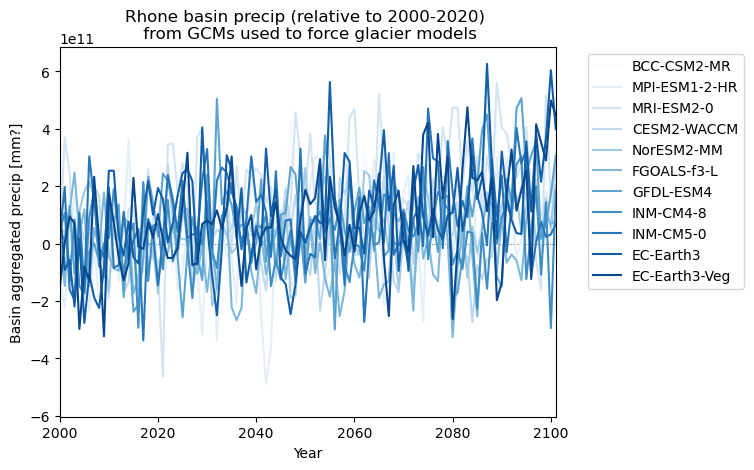

In [83]:
fig, ax = plt.subplots()
ax.axhline(0, color='k', ls=':', lw= 0.5)
for i,this_GCM in enumerate(modelnames):
    this_precip = pd.Series(P_by_basin[this_basin]['Ssp4p5'][this_GCM])
    this_precip.index=rng
    hist_mean = this_precip['2000-01-31':'2020-12-31'].resample('A').sum().mean()
    ax.plot((this_precip.resample('A').sum()-hist_mean), label=this_GCM, color=default_colors(i/len(modelnames)))
ax.legend(bbox_to_anchor=(1.05, 1.0), ncol=1)

ax.set(xlim=(pd.datetime(1999,12,31),pd.datetime(2100,12,31)),
      xlabel='Year',
      ylabel='Basin aggregated precip [mm?]',
      title='{} basin precip (relative to 2000-2020) \n from GCMs used to force glacier models'.format(str.capitalize(this_basin)));

/var/folders/1w/5s0157gx20d0jd0hrtvmpmh40000gp/T/ipykernel_1531/1773847904.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.set(xlim=(pd.datetime(1999,12,31),pd.datetime(2100,12,31)),


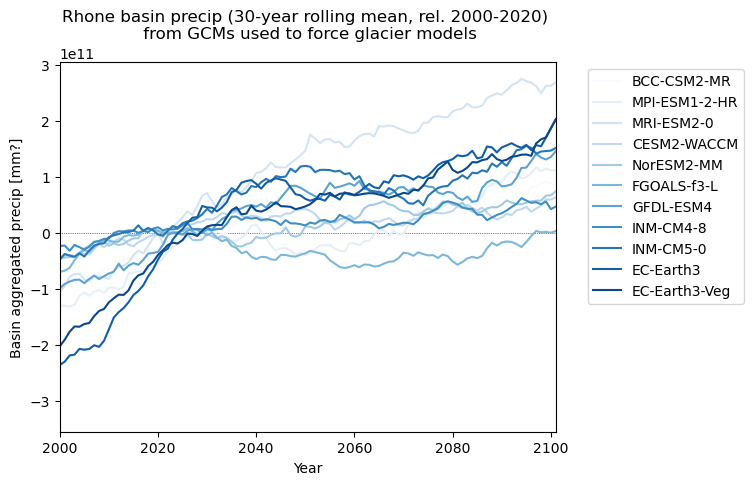

In [84]:
fig, ax = plt.subplots()
ax.axhline(0, color='k', ls=':', lw= 0.5)
for i,this_GCM in enumerate(modelnames):
    this_precip = pd.Series(P_by_basin[this_basin]['Ssp4p5'][this_GCM])
    this_precip.index=rng
    hist_mean = this_precip['2000-01-31':'2020-12-31'].resample('A').sum().mean()
    ax.plot((this_precip.resample('A').sum()-hist_mean).rolling(window=30).mean(), label=this_GCM, color=default_colors(i/len(modelnames)))
ax.legend(bbox_to_anchor=(1.05, 1.0), ncol=1)

ax.set(xlim=(pd.datetime(1999,12,31),pd.datetime(2100,12,31)),
      xlabel='Year',
      ylabel='Basin aggregated precip [mm?]',
      title='{} basin precip (30-year rolling mean, rel. 2000-2020) \n from GCMs used to force glacier models'.format(str.capitalize(this_basin)));

Looks like all of these GCMs have increasing precip in the Rhone over the 21st century.  This is not representative of the CMIP archive that Sloan visualized!  Let's correct the units soon and analyse some other basins.

Correct the units by:
-Dividing by area of basin?

## Spot check a few other basins

Text(0.02, 0.5, 'Basin aggregated precip [mm?]')

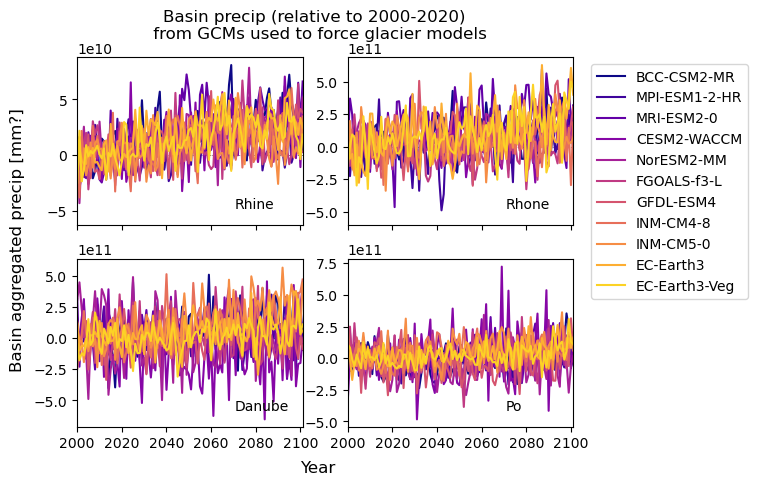

In [113]:
test_basins = ['RHINE', 'RHONE', 'DANUBE', 'PO']

fig, axs = plt.subplots(2,2, sharex=True)
for i, ax in enumerate(axs.ravel()):
    this_basin = test_basins[i]
    basin_label = ' '.join([s.capitalize() for s in this_basin.split(' ')])
    
    ax.axhline(0, color='k', ls=':', lw= 0.5)
    for i,this_GCM in enumerate(modelnames):
        this_precip = pd.Series(P_by_basin[this_basin]['Ssp4p5'][this_GCM])
        this_precip.index=rng
        hist_mean = this_precip['2000-01-31':'2020-12-31'].resample('A').sum().mean()
        ax.plot((this_precip.resample('A').sum()-hist_mean), label=this_GCM, color=default_colors(i/len(modelnames)))

    ax.set(xlim=(datetime.datetime(1999,12,31),datetime.datetime(2100,12,31)))
    ax.text(0.7, 0.1, basin_label, transform=ax.transAxes)

axs[0,1].legend(bbox_to_anchor=(1.05, 1.0), ncol=1)
fig.suptitle('Basin precip (relative to 2000-2020) \n from GCMs used to force glacier models')
fig.supxlabel('Year')
fig.supylabel('Basin aggregated precip [mm?]')

Text(0.02, 0.5, 'Basin aggregated precip [mm?]')

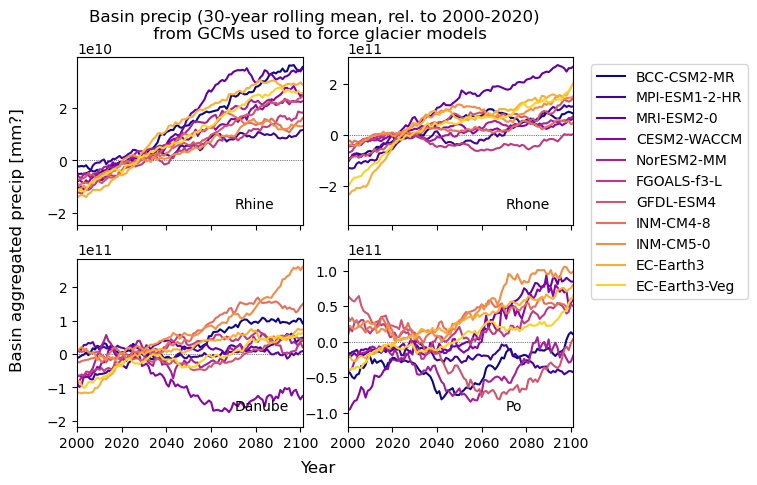

In [114]:
fig, axs = plt.subplots(2,2, sharex=True)
for i, ax in enumerate(axs.ravel()):
    this_basin = test_basins[i]
    basin_label = ' '.join([s.capitalize() for s in this_basin.split(' ')])
    
    ax.axhline(0, color='k', ls=':', lw= 0.5)
    for i,this_GCM in enumerate(modelnames):
        this_precip = pd.Series(P_by_basin[this_basin]['Ssp4p5'][this_GCM])
        this_precip.index=rng
        hist_mean = this_precip['2000-01-31':'2020-12-31'].resample('A').sum().mean()
        ax.plot((this_precip.resample('A').sum()-hist_mean).rolling(window=30).mean(), label=this_GCM, color=default_colors(i/len(modelnames)))

    ax.set(xlim=(datetime.datetime(1999,12,31),datetime.datetime(2100,12,31)))
    ax.text(0.7, 0.1, basin_label, transform=ax.transAxes)

axs[0,1].legend(bbox_to_anchor=(1.05, 1.0), ncol=1)
fig.suptitle('Basin precip (30-year rolling mean, rel. to 2000-2020) \n from GCMs used to force glacier models')
fig.supxlabel('Year')
fig.supylabel('Basin aggregated precip [mm?]')